In [1]:
import os
# List the files in the input directory to see the competition dataset
input_dir = '/kaggle/input/'
print(os.listdir(input_dir))


['computer-vision-xm', 'test-images']


1. Business problem: This is a competition based on "Computer Vision", where the participants have to deploy a model that will be able to classify a healthy leaf of a plant from a diseased leaf. The model will have a great potential to assist farmers, increase productivity, and promote sustainable practices.
   
2. Dataset: The size is 6.91 GB with 4239 files which includes 4236 images and 3 csv files. You can download the dataset from [here] (https://www.kaggle.com/datasets/amandam1/healthy-vs-diseased-leaf-image-dataset).
3. Pipeline:
   1.  Import all necessary libraries for Pytorch implementation.
   2.  Analyze the dataset.
   3.  Create a CustomDataset and incoporate it into DalaLoader.
   4.  Load a pretrained model and fine tune it for maximum accuracy.
   5.  Train the model.
   6.  Evaluate the model.
   7.  Plot graph for loss and accuracy.
   8.  Use the model to test on test_loader.
   9.  Finally inference.

**Import Libraries**

1. tqdm is a python library used to display a progress bar during training.
2. DataLoader is a Pytorch tool that helps to load shuffle data in batches use them easily during training.


In [2]:
import pandas as pd
import torch
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,random_split
import torch.nn as nn
import torchvision.models as models

**Data Analysis**

1. Check for any null values.
2. Visualise an 4 images and check if the image and the label is matching.
3. Check for the shape of the images for resolution and the number of channels.

In [23]:
df = pd.read_csv("/kaggle/input/computer-vision-xm/train.csv")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3388 entries, 0 to 3387
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  3388 non-null   int64 
 1   Images      3388 non-null   object
 2   Labels      3388 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 79.5+ KB
None


Image: 0003_0074.JPG - Shape: (4000, 6000, 3)
Image: 0004_0182.JPG - Shape: (4000, 6000, 3)
Image: 0018_0063.JPG - Shape: (4000, 6000, 3)
Image: 0009_0284.JPG - Shape: (4000, 6000, 3)


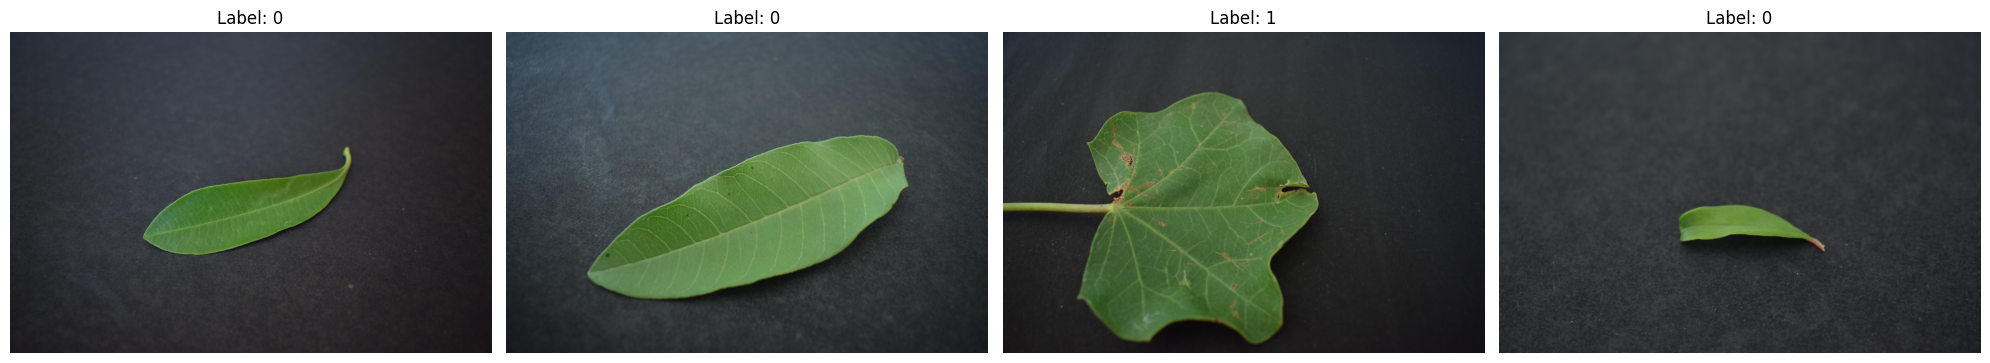

In [24]:
import os
import cv2
import pandas as pd
from matplotlib import pyplot as plt

# Path to your images folder and train.csv
images_folder = "/kaggle/input/computer-vision-xm/images/kaggle/working/Reorganized_Data/images"
train_csv_path = "/kaggle/input/computer-vision-xm/train.csv"

# Load the CSV file
train_data = pd.read_csv(train_csv_path)

# Initialize a counter to display only the first 4 images with labels
counter = 0

# Create a figure for displaying 4 images in a single row
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Iterate over the rows in the DataFrame
for _, row in train_data.iterrows():
    # Get image file name and label from the DataFrame
    filename = row['Images']  # Column name for the image file
    label = row['Labels']     # Column name for the label

    # Construct the full image path
    img_path = os.path.join(images_folder, filename)

    # Check if the file exists
    if os.path.exists(img_path):
        # Load the image
        image = cv2.imread(img_path)

        print(f"Image: {filename} - Shape: {image.shape}")

        # Display the image in the current subplot
        axes[counter].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axes[counter].set_title(f"Label: {label}")
        axes[counter].axis("off")

        # Increment counter after displaying an image
        counter += 1

        # Stop after displaying 4 images
        if counter == 4:
            break

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


**CustomDataset**

CustomDataset is built on torch.utils.data.Dataset, giving it a structure to load and process data. You can customize how the data is handled, including applying transformations. It works well with PyTorch’s DataLoader, which makes it easy to batch, shuffle, and prepare the data for training. In this particular case, we have a csv files that is used here to take the images and split it into train and test. Then we use transforms, the transformations ToTensor(), Resize(), and Normalize() are used to prepare images for neural networks. ToTensor() converts the image into a format that the model can use. Resize() makes sure all images have the same size. Normalize() adjusts the pixel values so they are on a similar scale, helping the model learn faster and more smoothly. These steps ensure that the data is ready and consistent for training.

In [14]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, img_dir, is_train=True, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.is_train = is_train  # Flag to differentiate between training and testing dataset
        self.transform = transform

    def __len__(self):
        # Return the number of samples in the dataset
        return len(self.data)

    def __getitem__(self, idx):
        # Get the image filename from the CSV and construct the full path
        img_name = os.path.join(self.img_dir, self.data.iloc[idx, 1])  
        
        # Open the image
        image = Image.open(img_name)
        
        # Apply the transformation if provided
        if self.transform:
            image = self.transform(image)
        
        if self.is_train:
           
            label = self.data.iloc[idx, 2] 
            return image, label
        else:
           
            return image

# Define transformations (if needed)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CSV files and create train and test datasets
train_csv = '/kaggle/input/computer-vision-xm/train.csv'  # Path to your train CSV
test_csv = '/kaggle/input/computer-vision-xm/test.csv'    # Path to your test CSV

# Image directory
img_dir = '/kaggle/input/computer-vision-xm/images/kaggle/working/Reorganized_Data/images'  # Adjust as per your structure

# Create train and test datasets
train_dataset = CustomDataset(csv_file=train_csv, img_dir=img_dir,  is_train=True, transform=transform)
test_dataset = CustomDataset(csv_file=test_csv, img_dir=img_dir,  is_train=False, transform=transform)

**DataLoader**

Since, I need to check for validation accuracy,  I decided to split the train dataset by maintaing 80% data and sharing the remaining to the validation dataset. Finally, I was able to create Dataloader for train, val and test.

In [15]:
# Split the dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Define the DataLoader for training
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True, num_workers=2)

# Define the DataLoader for validation
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False, num_workers=2)

# Define the DataLoader for testing (no need to shuffle test data)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

However, it is very important to analyze the data within the dataloader before feeding it to the model. The shape of the data should be complatible with the expected input by the model otherwise, we are bound to face difficulties while training the model.

In [21]:
def check_loader(loader, loader_name):
    print(f"\nChecking {loader_name}...")
    for batch_idx, (images, labels) in enumerate(loader):
        print(f"Batch {batch_idx + 1}:")
        print(f"  Images shape: {images.shape}")
        print(f"  Labels shape: {labels.shape}")
        print(f"  Labels: {labels[:5].tolist()}")  # Print the first 5 labels
        break  # Check only the first batch

# Check each DataLoader
check_loader(train_loader, "Train Loader")
check_loader(val_loader, "Validation Loader")


Checking Train Loader...
Batch 1:
  Images shape: torch.Size([64, 3, 128, 128])
  Labels shape: torch.Size([64])
  Labels: [1, 1, 0, 1, 0]

Checking Validation Loader...
Batch 1:
  Images shape: torch.Size([64, 3, 128, 128])
  Labels shape: torch.Size([64])
  Labels: [0, 1, 0, 0, 1]


**Final Model**

Steps on my final model:
1. I used vgg50 and it was too slow due to its complexity.
2. I used vgg16 and freezed first 5 layers , the val_accuracy was approx.50%.
3. I used vgg16 and freezed first 8 layers, the val_accuracy increased to approx.70%.
4. I used vgg16 and freezed all convolution laye (dropout=0.3), val_the accuracy increased to 93%.
5. I used vgg16 and freezed all convolution laye (dropout=0.4), val_the accuracy decreased to 92%.
6. I used resnet18 and freezed all convolution layers, va_accuracy remained same 92%.
Therefore, I have decided to submit 4th approach in the competition.
(I did try basic segmentation on the images and fed those images into the model but, there wasn't much effect. so, I decided to drop it because it was occupying additional space in my kaggle.)

In [26]:
class CustomVGG16(nn.Module):
    def __init__(self):
        super().__init__()

        # Using the pre-trained VGG16 convolutional layers
        vgg16 = models.vgg16(pretrained=True)
        self.conv_base = vgg16.features  # Only convolutional layers from VGG16
        
        # Freeze all layers
        for param in self.conv_base.parameters():
            param.requires_grad = False

        # Adaptive pooling to get a fixed output size regardless of input dimensions
        self.adaptive_pool = nn.AdaptiveAvgPool2d((5, 5))  # Output size (5, 5)

        # Custom classifier for binary classification
        self.classifier = nn.Sequential(
            nn.Flatten(),                        # Flatten the feature map to a 1D vector
            nn.Linear(512 * 5 * 5, 256),         # Adjust dimensions to match the pooled output size
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),                   # Output layer: 1 unit for binary classification
        )

    def forward(self, x):
        x = self.conv_base(x)  # Pass through convolutional layers
        x = self.adaptive_pool(x)  # Adaptive pooling to ensure fixed output size
        x = self.classifier(x)  # Pass through the custom classifier
        return x

# Instantiate the model
model = CustomVGG16()


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


I wanted to check if the output is as expected to avoid issue while processing loss.

In [30]:
dummy_input = torch.randn(64, 3, 128, 128)

# Pass the dummy input through the model
output = model(dummy_input)

# Check the output
print(output.shape)

torch.Size([64, 1])


It is very clear from the summary that all the parameters in the convolution layers are freezed and used as feature extractor. Also, Pooling and activation function(ReLU)  does not contribute to parameters. We are using maxpooling to reduce the dimension by half and ReLU to introduce non-linearity.

In [24]:
from torchsummary import summary
# Display the summary of the model for an input size of 224x224 (as VGG16 expects this input size)
summary(model, input_size=(3, 128, 128))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
              ReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3         [-1, 64, 128, 128]          36,928
              ReLU-4         [-1, 64, 128, 128]               0
         MaxPool2d-5           [-1, 64, 64, 64]               0
            Conv2d-6          [-1, 128, 64, 64]          73,856
              ReLU-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
              ReLU-9          [-1, 128, 64, 64]               0
        MaxPool2d-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]         295,168
             ReLU-12          [-1, 256, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         590,080
             ReLU-14          [-1, 256,

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


**Training**

1. The loss function suitable for this task was BCEWithLogitsLoss() because this is a binary classification task. It combines Binary Cross Entropy and sigmoid function.
2. I used AdamW as an optimizer due to its preference over Adam incase of deploying pretrained model.
3. I used very less epochs and patience becasue of the time constraints, also checkpoints to resume incase of interruption.
4.  model.train() to update the parameters during training.
5.  model.eval() to undo parameters update during evaluation.
6.  I used early stopping to save time on unnecessary training after there is no more learning left for the model.

In [7]:
# Checkpoint file path
checkpoint_file = 'best_model_checkpoint.pth'

# Move the model to GPU if available
model.to(device)

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# Training configuration
epochs = 10
patience = 3
patience_counter = 0

# Lists to store loss values for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Load checkpoint if exists
start_epoch = 0
if os.path.exists(checkpoint_file):
    checkpoint = torch.load(checkpoint_file)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_val_loss = checkpoint['val_loss'][-1]  # Load last best validation loss
    train_losses = checkpoint['train_loss']
    train_accuracies = checkpoint['train_accuracy']
    val_losses = checkpoint['val_loss']
    val_accuracies = checkpoint['val_accuracy']
    print(f"Resuming training from epoch {start_epoch}")
else:
    best_val_loss = float('inf')

# Training loop
for epoch in range(start_epoch, epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    
    # Training phase
    model.train()
    running_train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(device), labels.float().to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs.squeeze(), labels)
        running_train_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        predictions = torch.sigmoid(outputs).squeeze() > 0.5
        train_correct += (predictions == labels).sum().item()
        train_total += labels.size(0)

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = 100 * train_correct / train_total
    train_accuracies.append(train_accuracy)
    print(f'Training loss: {avg_train_loss:.4f}, Training accuracy: {train_accuracy:.2f}%')


    # Validation phase
    model.eval()
    running_val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation"):
            images, labels = images.to(device), labels.float().to(device)

            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels)
            running_val_loss += loss.item()

            # Calculate validation accuracy
            predictions = torch.sigmoid(outputs).squeeze() > 0.5
            val_correct += (predictions == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = 100 * val_correct / val_total
    val_accuracies.append(val_accuracy)
    print(f'Validation loss: {avg_val_loss:.4f}, Validation accuracy: {val_accuracy:.2f}%')


    # Early stopping and checkpoint saving
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_losses,
            'val_accuracy': val_accuracies,
            'train_loss': train_losses,
            'train_accuracy': train_accuracies
        }
        torch.save(checkpoint, checkpoint_file)
        print("Best model updated")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break



Epoch 1/10


Training:   0%|          | 0/43 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Training: 100%|██████████| 43/43 [23:45<00:00, 24.18s/it]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Training: 100%|██████████| 43/43 [23:45<00:00, 33.14s/it]


Training loss: 0.4141, Training accuracy: 81.66%


Validation: 100%|██████████| 11/11 [06:13<00:00, 33.93s/it]


Validation loss: 0.2241, Validation accuracy: 89.97%
Best model updated
Epoch 2/10


Training: 100%|██████████| 43/43 [23:52<00:00, 33.31s/it]


Training loss: 0.2123, Training accuracy: 90.92%


Validation: 100%|██████████| 11/11 [05:58<00:00, 32.62s/it]


Validation loss: 0.1949, Validation accuracy: 90.71%
Best model updated
Epoch 3/10


Training: 100%|██████████| 43/43 [22:43<00:00, 31.71s/it]


Training loss: 0.1741, Training accuracy: 93.25%


Validation: 100%|██████████| 11/11 [06:05<00:00, 33.27s/it]


Validation loss: 0.2197, Validation accuracy: 90.27%
Epoch 4/10


Training: 100%|██████████| 43/43 [23:14<00:00, 32.42s/it]


Training loss: 0.1267, Training accuracy: 95.24%


Validation: 100%|██████████| 11/11 [06:11<00:00, 33.78s/it]


Validation loss: 0.1670, Validation accuracy: 92.48%
Best model updated
Epoch 5/10


Training: 100%|██████████| 43/43 [22:59<00:00, 32.07s/it]


Training loss: 0.1203, Training accuracy: 95.54%


Validation: 100%|██████████| 11/11 [06:10<00:00, 33.67s/it]


Validation loss: 0.2237, Validation accuracy: 91.59%
Epoch 6/10


Training: 100%|██████████| 43/43 [23:54<00:00, 33.37s/it]


Training loss: 0.0861, Training accuracy: 97.05%


Validation: 100%|██████████| 11/11 [06:08<00:00, 33.52s/it]


Validation loss: 0.1714, Validation accuracy: 92.63%
Epoch 7/10


Training: 100%|██████████| 43/43 [23:43<00:00, 33.10s/it]


Training loss: 0.0691, Training accuracy: 97.68%


Validation: 100%|██████████| 11/11 [06:14<00:00, 34.03s/it]


Validation loss: 0.1666, Validation accuracy: 92.92%
Best model updated
Epoch 8/10


Training: 100%|██████████| 43/43 [22:37<00:00, 31.56s/it]


Training loss: 0.0570, Training accuracy: 97.97%


Validation: 100%|██████████| 11/11 [06:02<00:00, 32.91s/it]


Validation loss: 0.1754, Validation accuracy: 93.36%
Epoch 9/10


Training: 100%|██████████| 43/43 [23:57<00:00, 33.42s/it]


Training loss: 0.0434, Training accuracy: 98.71%


Validation: 100%|██████████| 11/11 [06:11<00:00, 33.81s/it]


Validation loss: 0.1836, Validation accuracy: 93.81%
Epoch 10/10


Training: 100%|██████████| 43/43 [23:54<00:00, 33.36s/it]


Training loss: 0.0328, Training accuracy: 99.19%


Validation: 100%|██████████| 11/11 [06:19<00:00, 34.49s/it]

Validation loss: 0.1766, Validation accuracy: 93.36%
Early stopping triggered


**Plot**

Visualize the results.

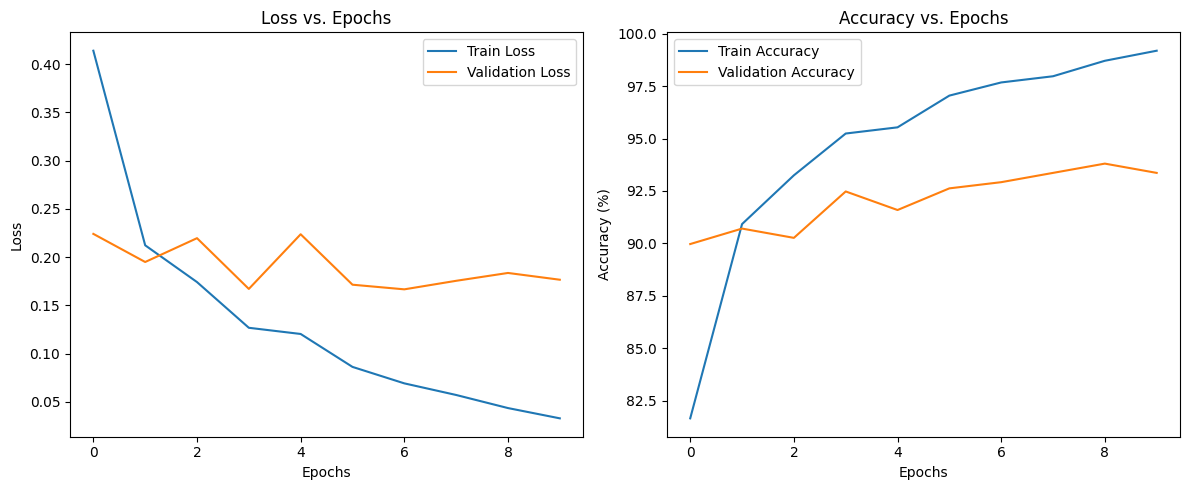

In [11]:
import matplotlib.pyplot as plt
# Plotting the loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs. Epochs')
plt.legend()

plt.tight_layout()
plt.show()


Finally, After training the model, this is where I use my test data to see if the model is working as expected. Most importantly, we have to set the model to eval() state to avoid further parameters upgrade. 

/tmp/ipykernel_30/2524502684.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_file)


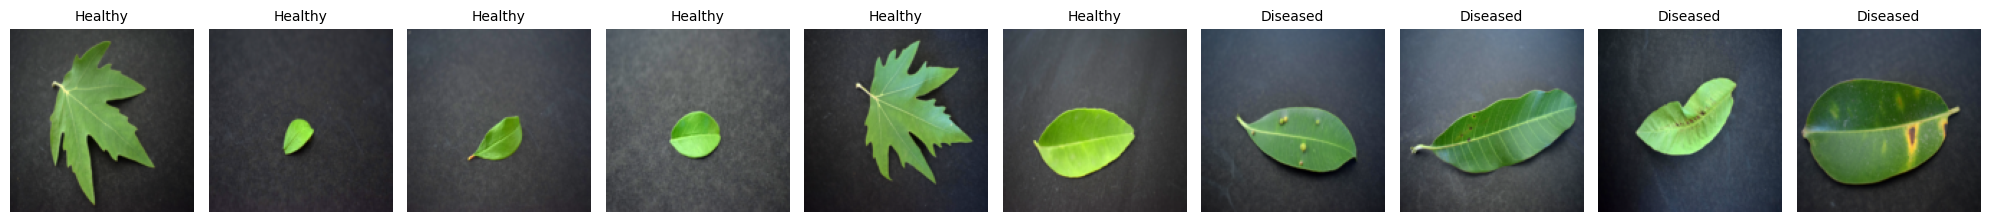

In [12]:

# Define the model architecture (same as during training)
model = CustomVGG16()  # Replace MyModel with your actual model class

# Load the checkpoint
checkpoint = torch.load(checkpoint_file)

# Load the model state dictionary
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()  # Set the model to evaluation mode

# Get predictions and corresponding images
predictions = []
images_to_display = []

with torch.no_grad():
    for images in test_loader:  # Only images in the test loader
        images = images.to(device)
        outputs = model(images)
        
        # Convert logits to binary predictions (Healthy/Diseased)
        preds = (torch.sigmoid(outputs).squeeze() > 0.5).cpu().numpy()
        preds_mapped = ["Diseased" if pred else "Healthy" for pred in preds]
        predictions.extend(preds_mapped)

        images_to_display.extend(images.cpu().numpy())
        if len(predictions) >= 10:  # Stop after getting 10 predictions
            break

# Visualize the first 10 images with their predictions
fig, axes = plt.subplots(1, 10, figsize=(20, 5))
for idx, ax in enumerate(axes):
    # Denormalize images for display if normalized during preprocessing
    img = images_to_display[idx].transpose(1, 2, 0)  # Convert CHW to HWC
    img = (img - img.min()) / (img.max() - img.min())  # Scale to [0, 1] range
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(predictions[idx], fontsize=10)
plt.tight_layout()
plt.show()


**Inference Pipeline**

1. Download some images from google.
2. Load the images and perform the same transformation on the new images as we did in CustomDataset.
3. Load the saved model.
4. Set the model to evaluation mode.
5. Input the images into the model and predict the class.
6. Finally, visualize the images with classification.


/tmp/ipykernel_30/2384636934.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_file)


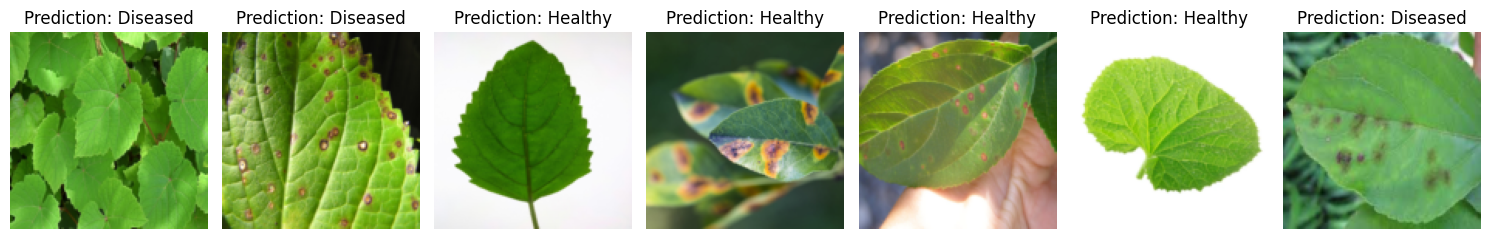

In [13]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Adjust values based on your training
])

# Define the folder where your images are stored
image_folder = '/kaggle/input/test-images'

# Get all image files in the folder (you can filter by extension if needed)
image_paths = [os.path.join(image_folder, filename) for filename in os.listdir(image_folder) 
               if filename.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Initialize the model (replace with your actual model)
model = CustomVGG16()  # Use the same model as you used during training
checkpoint_file = '/kaggle/working/best_model_checkpoint.pth'

# Load the checkpoint and model weights
checkpoint = torch.load(checkpoint_file)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()  # Set the model to evaluation mode

# Make predictions on each image
predictions = []
images_to_display = []

with torch.no_grad():
    for img_path in image_paths:
        # Open the image
        image = Image.open(img_path)
        
        # Apply transformations
        image = transform(image).unsqueeze(0).to(device)  # Add batch dimension
        
        # Get the model's output
        output = model(image)
        
        # Apply sigmoid and convert to binary prediction (Healthy/Diseased)
        pred = (torch.sigmoid(output).squeeze() > 0.5).cpu().numpy()
        predictions.append('Diseased' if pred else 'Healthy')
        
        
        images_to_display.append(image.cpu().numpy().squeeze().transpose(1, 2, 0))  # Convert from tensor to numpy

# Visualize the images with their predictions
fig, axes = plt.subplots(1, len(predictions), figsize=(15, 5))

for idx, ax in enumerate(axes):
    img = images_to_display[idx]
    img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1] for display
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'Prediction: {predictions[idx]}')

plt.tight_layout()
plt.show()


**The model is able to classify as healthy and diseased as long as the images are clear.**